In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ortho_group
import pickle
from sklearn.metrics import pairwise_distances, pairwise_kernels
import sklearn.gaussian_process as gp
from sklearn.gaussian_process.kernels import RBF
import networkx as nx
from tqdm.notebook import tqdm

import os
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning) 

import pandas as pd

import copy


import hypernetx as hnx

import pygenstability as pgs
from pygenstability import plotting

In [2]:
import networkx as nx
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import seaborn as sns

import scipy as sc
import scipy.sparse as sp

In [3]:
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

In [4]:
import random

random.seed(10)

In [5]:
# CHECKPOINT
edges_e = pickle.load(open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/dHSIC_found/dHSIC_Europe.pkl', 'rb'))
edges_as = pickle.load(open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/dHSIC_found/dHSIC_Asia.pkl', 'rb'))
edges_af = pickle.load(open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/dHSIC_found/dHSIC_Africa.pkl', 'rb'))
edges_am = pickle.load(open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/dHSIC_found/dHSIC_Americas.pkl', 'rb'))

In [6]:
# CHECKPOINT
Adj2_e = pickle.load(open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/dHSIC_found/Adj2_e.pkl', 'rb'))
Adj2_as = pickle.load(open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/dHSIC_found/Adj2_as.pkl', 'rb'))
Adj2_af = pickle.load(open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/dHSIC_found/Adj2_af.pkl', 'rb'))
Adj2_am = pickle.load(open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/dHSIC_found/Adj2_am.pkl', 'rb'))

In [7]:
# CHECKPOINT
Aw_e = pickle.load(open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/dHSIC_found/Adj_e.pkl', 'rb'))
Aw_as = pickle.load(open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/dHSIC_found/Adj_as.pkl', 'rb'))
Aw_af = pickle.load(open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/dHSIC_found/Adj_af.pkl', 'rb'))
Aw_am = pickle.load(open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/dHSIC_found/Adj_am.pkl', 'rb'))

In [8]:
def get_adjacency(H):
    
    """ Construct weighted adjacency matrix for HyperGraph H
    
    Arguments
    H : Hypernetx hypergraph object
    
    """

    incidence = H.incidence_matrix().toarray()
    
    # hyperedge adjacency matrix
    C = np.matmul(incidence.T,incidence)
    A = np.matmul(incidence,incidence.T)

    R = np.matmul(incidence, np.matmul(np.diag(np.diag(C)),incidence.T))

    # defining transition matrix
    adj = R - A
    np.fill_diagonal(adj,0)

    
    return adj

In [9]:
def compute_and_plot_eigenvector_hypergraph(g, pos, n_labels, weight=True):
    plt.figure(figsize=(10,6))
    g.edges(data=True)
    if weight==True:
        ec = nx.eigenvector_centrality(g, weight='weight')
    else:
        ec = nx.eigenvector_centrality(g)
    colors = list(ec.values())

    cmap=plt.cm.Blues
    vmin = min(colors)
    vmax = max(colors)
    nx.draw(g,pos=pos,node_size=800,node_color=colors,cmap=cmap,vmin=vmin, vmax=vmax)
    labels=nx.draw_networkx_labels(g,pos, labels=n_labels)

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
    sm._A = []
    plt.colorbar(sm)
    plt.show()
    
    return ec

In [10]:
colors_SDG = {1:(229/255, 36/255, 59/255), 2:(221/255, 166/255, 58/255), 3:(76/255, 159/255, 56/255), 
              4: (197/255, 25/255, 45/255), 5:(1, 58/255, 33/255), 6: (38/255, 189/255, 226/255),
              7: (252/255,195/255, 11/255), 8: (162/255,25/255, 66/255), 9: (253/255, 105/255, 37/255),
              10: (221/255, 19/255, 103/255), 11: (253/255, 157/255, 36/255), 12:(191/255, 139/255, 46/255), 
              13: (63/255, 126/255, 68/255), 14: (10/255, 151/255, 217/255), 15: (86/255, 192/255, 43/255),
              16: (0, 104/255, 157/255), 17:(25/255, 72/255, 106/255) }

In [11]:
def plot_eig_centralities_reorg(G,  n_labels, name, shortname, colors=colors_SDG):
    degree = nx.eigenvector_centrality(G,  weight='weight')
    
    num = len(n_labels)
    
    values = list(degree.values())
    values_reorg = np.zeros(17)
    for j in range(num):
        sdg_ind = int(n_labels[j])
        values_reorg[sdg_ind-1] = values[j]
    
    
    
    labels = []
    for i in range(17):
        labels.append('SDG {}'.format(i+1))
        
    colors_list = []
    for i in range(17):
        colors_list.append(colors[i+1])
    
    width = 0.94
    plt.figure(figsize=(18,10))
    plt.tight_layout() 
    
    plt.bar(x=labels, height=values_reorg, width=width, color = colors_list, align='center')
    
    for i, (label, value) in enumerate(zip(labels, values_reorg)):
        img = mpimg.imread('/Users/saravallejomengod/MathsYear4/M4R/utils/SDG_icons/SDG-{}.png'.format(i+1))
        plt.imshow(img, extent=[i-width/2,i + width/2-0.01,  value - 0.052, value-0.002 ], aspect='auto', zorder=2)
        
    
    plt.ylim(0, max(values_reorg) * 1.05)
    plt.xlim(-0.5, len(values_reorg)-0.5 )
    
    plt.xticks(fontsize=13)
    
    plt.ylabel('Eigenvector centrality', x=-0.06, fontdict={'fontsize': 18})
    plt.title(name, y=1.05, fontdict={'fontsize': 46})
    
    plt.savefig('/Users/saravallejomengod/MathsYear4/M4R/utils/hx/{}_EC.png'.format(shortname), format='png', bbox_inches='tight')
    plt.show()

In [12]:
def plot_restricted_hypergraphs(H, name, shortname):
    plt.figure(figsize=(10,10))
    plt.tight_layout() 
    plt.title(name, fontdict={'fontsize': 30})
    
    hnx.draw(H, with_edge_labels=False, 
             node_labels_kwargs={'fontsize': 16}, pos=nx.circular_layout(H))
    plt.savefig('/Users/saravallejomengod/MathsYear4/M4R/utils/hx/{}_3.png'.format(shortname), format='png',bbox_inches='tight')
  

# America

## Hypergraph

In [13]:
H_am = hnx.Hypergraph(edges_am)

## 3-way edges

In [17]:
Ham_restrict_edges3 = H_am.restrict_to_edges(list(e for e in edges_am if len(edges_am[e])==3))

# weighted adjacency matrix
graph_am3 = sp.csr_matrix(get_adjacency(Ham_restrict_edges3))

# construct network object for plotting
g_am3 = nx.Graph(graph_am3)
pos_am3 = nx.circular_layout(g_am3, scale=1)

# node names
Ham_restrict_edges3.nodes

EntitySet(_:Nodes,['7', '11', '3', '13', '9', '6', '14', '5', '1', '2', '4', '12', '8', '10', '17', '15'],{})

In [18]:
# create dictionary with node names
n_labels_am3 = {}
#copy nodes printed above to have the same order
nodes_am3 = ['7', '11', '3', '13', '9', '6', '14', '5', '1', '2', '4', '12', '8', '10', '17', '15']
for i in range(len(nodes_am3)):
    n_labels_am3[i] = nodes_am3[i]

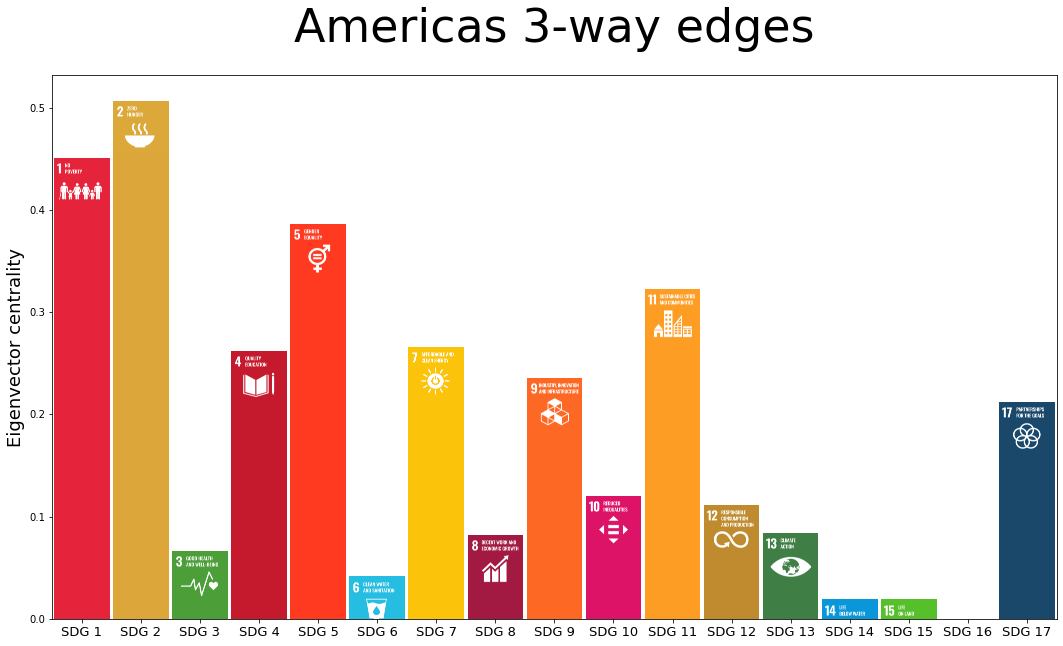

In [19]:
plot_eig_centralities_reorg(g_am3, n_labels_am3, "Americas 3-way edges", "AM3")

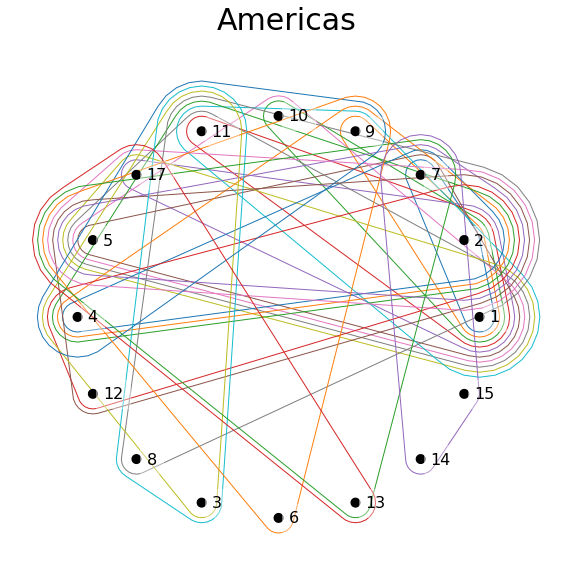

In [20]:
plot_restricted_hypergraphs(Ham_restrict_edges3, 'Americas', 'AM')

In [43]:
Ham_restrict_edges3

Hypergraph({43: Entity(43,['2', '7', '1'],{}), 44: Entity(44,['2', '9', '1'],{}), 45: Entity(45,['2', '10', '1'],{}), 46: Entity(46,['2', '11', '1'],{}), 47: Entity(47,['2', '17', '1'],{}), 48: Entity(48,['7', '5', '1'],{}), 49: Entity(49,['10', '5', '1'],{}), 50: Entity(50,['11', '5', '1'],{}), 51: Entity(51,['17', '5', '1'],{}), 52: Entity(52,['11', '9', '1'],{}), 53: Entity(53,['2', '7', '4'],{}), 54: Entity(54,['2', '9', '4'],{}), 55: Entity(55,['2', '11', '4'],{}), 56: Entity(56,['2', '12', '4'],{}), 57: Entity(57,['2', '7', '5'],{}), 58: Entity(58,['2', '12', '5'],{}), 59: Entity(59,['2', '17', '5'],{}), 60: Entity(60,['2', '11', '8'],{}), 61: Entity(61,['11', '3', '4'],{}), 62: Entity(62,['11', '3', '8'],{}), 63: Entity(63,['11', '9', '4'],{}), 64: Entity(64,['9', '6', '5'],{}), 65: Entity(65,['7', '13', '5'],{}), 66: Entity(66,['17', '13', '5'],{}), 67: Entity(67,['7', '14', '15'],{})},name=_)

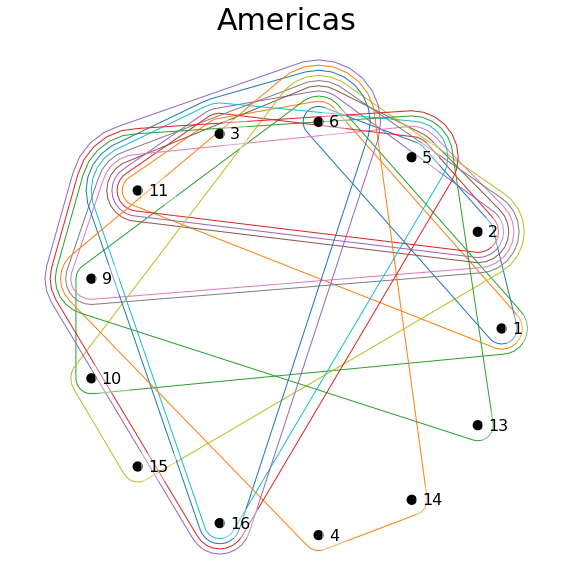

In [14]:
Ham_restrict_edges4 = H_am.restrict_to_edges(list(e for e in edges_am if len(edges_am[e])==4))
plot_restricted_hypergraphs(Ham_restrict_edges4, 'Americas', 'AM4')

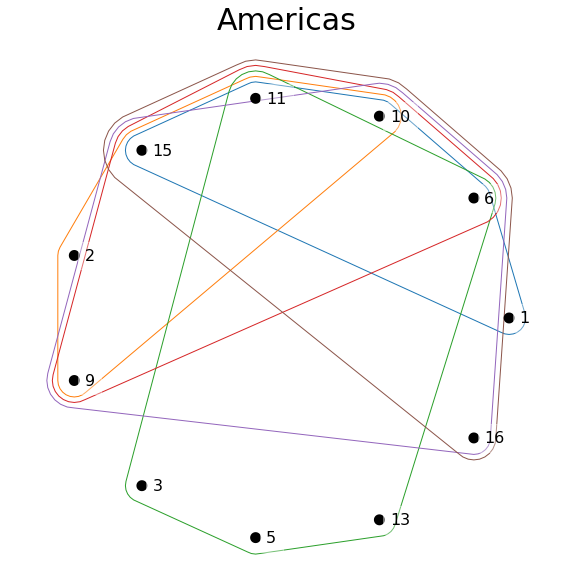

In [15]:
Ham_restrict_edges5 = H_am.restrict_to_edges(list(e for e in edges_am if len(edges_am[e])==5))
plot_restricted_hypergraphs(Ham_restrict_edges5, 'Americas', 'AM5')

# Europe

## Hypergraph

In [16]:
H_e = hnx.Hypergraph(edges_e)

# 3-way edges

In [23]:
He_restrict_edges3 = H_e.restrict_to_edges(list(e for e in edges_e if len(edges_e[e])==3))

# weighted adjacency matrix
graph_e3 = sp.csr_matrix(get_adjacency(He_restrict_edges3))

# construct network object for plotting
g_e3 = nx.Graph(graph_e3)
pos_e3 = nx.circular_layout(g_e3, scale=1)

# node names
He_restrict_edges3.nodes

EntitySet(_:Nodes,['7', '13', '6', '14', '5', '1', '12', '16', '10', '4'],{})

In [24]:
# create dictionary with node names
n_labels_e3 = {}
nodes_e3 = ['7', '13', '6', '14', '5', '1', '12', '16', '10', '4']
for i in range(len(nodes_e3)):
    n_labels_e3[i] = nodes_e3[i]

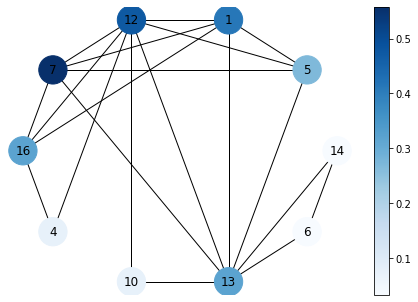

In [59]:
ec_e3 = compute_and_plot_eigenvector_hypergraph(g_e3, pos_e3, n_labels_e3)

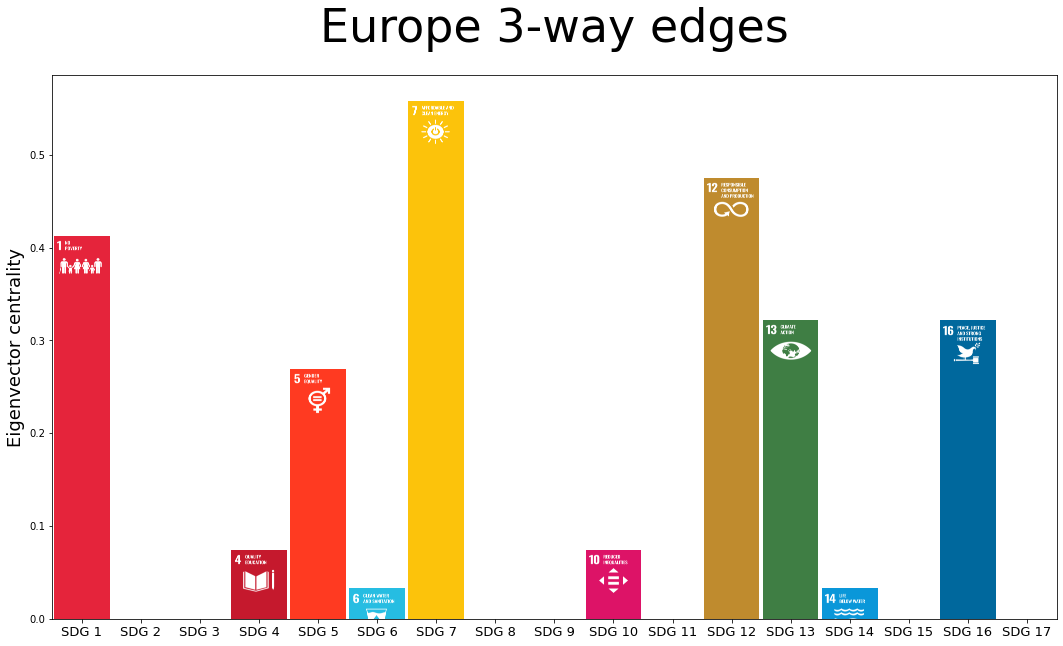

In [25]:
plot_eig_centralities_reorg(g_e3, n_labels_e3, "Europe 3-way edges", "E3")

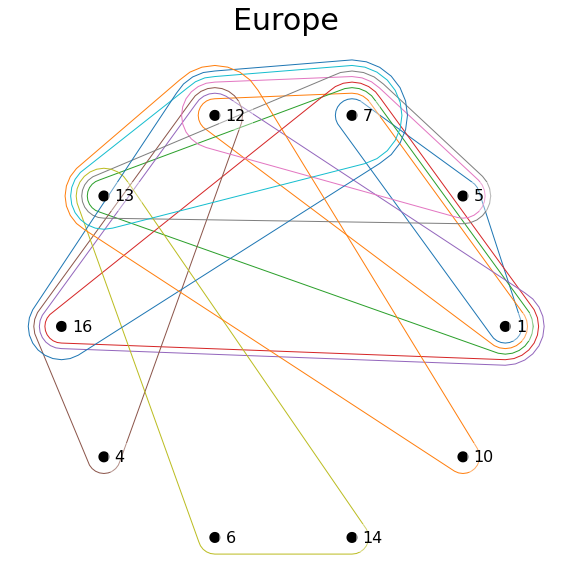

In [27]:
plot_restricted_hypergraphs(He_restrict_edges3, 'Europe', 'E')

In [40]:
He_restrict_edges3

Hypergraph({81: Entity(81,['7', '5', '1'],{}), 82: Entity(82,['7', '12', '1'],{}), 83: Entity(83,['7', '13', '1'],{}), 84: Entity(84,['7', '16', '1'],{}), 85: Entity(85,['12', '16', '1'],{}), 86: Entity(86,['12', '16', '4'],{}), 87: Entity(87,['7', '12', '5'],{}), 88: Entity(88,['7', '13', '5'],{}), 89: Entity(89,['14', '13', '6'],{}), 90: Entity(90,['7', '12', '13'],{}), 91: Entity(91,['7', '12', '16'],{}), 92: Entity(92,['13', '12', '10'],{})},name=_)

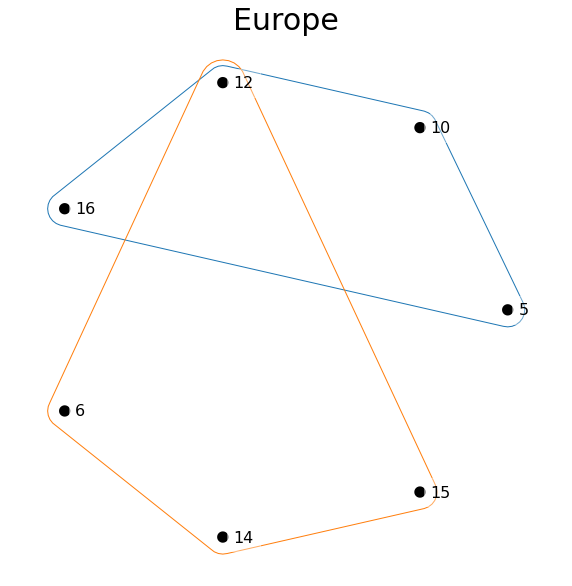

In [17]:
He_restrict_edges4 = H_e.restrict_to_edges(list(e for e in edges_e if len(edges_e[e])==4))
plot_restricted_hypergraphs(He_restrict_edges4, 'Europe', 'E4')

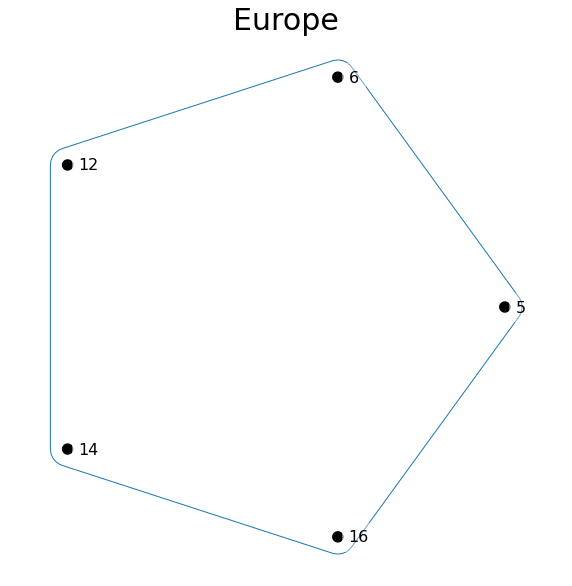

In [19]:
He_restrict_edges5 = H_e.restrict_to_edges(list(e for e in edges_e if len(edges_e[e])==5))
plot_restricted_hypergraphs(He_restrict_edges5, 'Europe', 'E5')

# Asia

## Hypergraph

In [21]:
H_as = hnx.Hypergraph(edges_as)

## 3-way edges

In [30]:
Has_restrict_edges3 = H_as.restrict_to_edges(list(e for e in edges_as if len(edges_as[e])==3))

# weighted adjacency matrix
graph_as3 = sp.csr_matrix(get_adjacency(Has_restrict_edges3))

# construct network object for plotting
g_as3 = nx.Graph(graph_as3)
pos_as3 = nx.circular_layout(g_as3, scale=1)

# node names
Has_restrict_edges3.nodes

EntitySet(_:Nodes,['13', '3', '6', '9', '5', '1', '2', '8', '10'],{})

In [31]:
# create dictionary with node names
n_labels_as3 = {}
nodes_as3 = ['13', '3', '6', '9', '5', '1', '2', '8', '10']
for i in range(len(nodes_as3)):
    n_labels_as3[i] = nodes_as3[i]

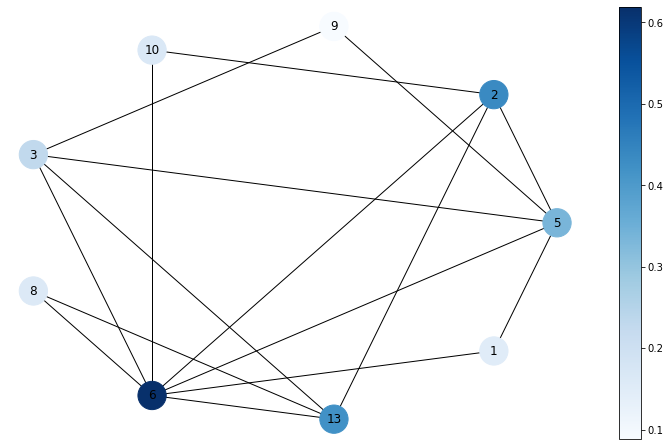

In [108]:
ec_as3 = compute_and_plot_eigenvector_hypergraph(g_as3, pos_as3, n_labels_as3)

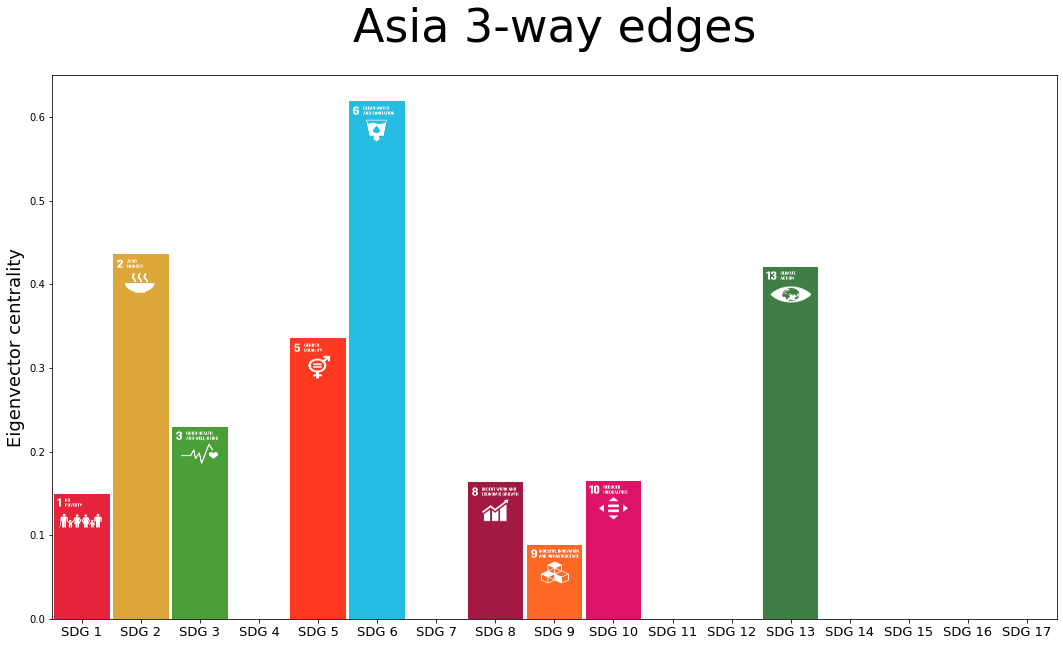

In [32]:
plot_eig_centralities_reorg(g_as3, n_labels_as3, "Asia 3-way edges", "AS3")

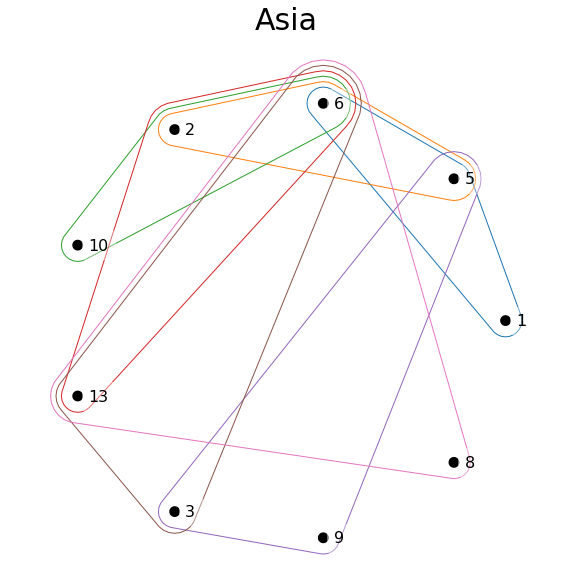

In [33]:
plot_restricted_hypergraphs(Has_restrict_edges3, 'Asia', 'AS')

In [41]:
Has_restrict_edges3

Hypergraph({82: Entity(82,['6', '5', '1'],{}), 83: Entity(83,['2', '6', '5'],{}), 84: Entity(84,['2', '10', '6'],{}), 85: Entity(85,['2', '13', '6'],{}), 86: Entity(86,['9', '3', '5'],{}), 87: Entity(87,['13', '3', '6'],{}), 88: Entity(88,['13', '8', '6'],{})},name=_)

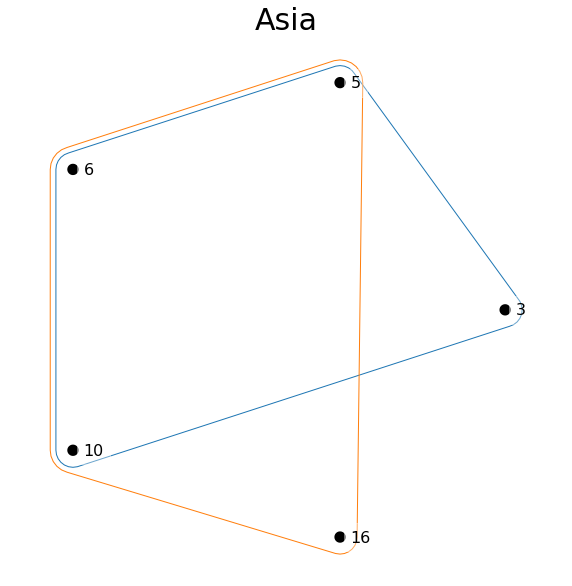

In [22]:
Has_restrict_edges4 = H_as.restrict_to_edges(list(e for e in edges_as if len(edges_as[e])==4))
plot_restricted_hypergraphs(Has_restrict_edges4, 'Asia', 'AS4')

# Africa
## Hypergraph

In [23]:
H_af = hnx.Hypergraph(edges_af)

## 3-way edges

In [36]:
Haf_restrict_edges3 = H_af.restrict_to_edges(list(e for e in edges_af if len(edges_af[e])==3))

# weighted adjacency matrix
graph_af3 = sp.csr_matrix(get_adjacency(Haf_restrict_edges3))

# construct network object for plotting
g_af3 = nx.Graph(graph_af3)
pos_af3 = nx.circular_layout(g_af3, scale=1)

# node names
Haf_restrict_edges3.nodes

EntitySet(_:Nodes,['7', '11', '3', '13', '6', '9', '14', '5', '1', '2', '12', '8', '16', '10', '17', '15'],{})

In [37]:
# create dictionary with node names
n_labels_af3 = {}
nodes_af3 = ['7', '11', '3', '13', '6', '9', '14', '5', '1', '2', '12', '8', '16', '10', '17', '15']
for i in range(len(nodes_af3)):
    n_labels_af3[i] = nodes_af3[i]

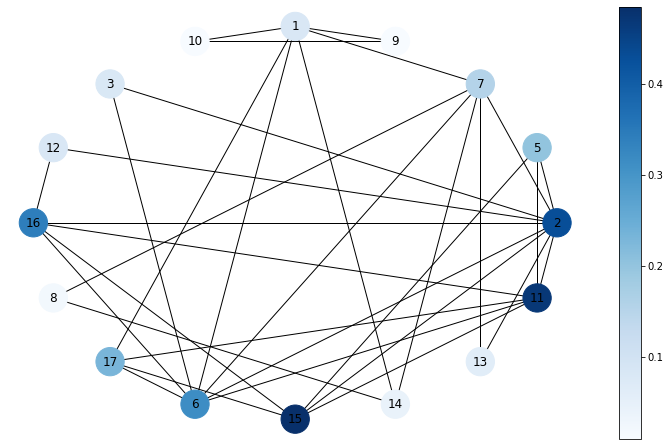

In [115]:
ec_af3 = compute_and_plot_eigenvector_hypergraph(g_af3, pos_af3, n_labels_af3)

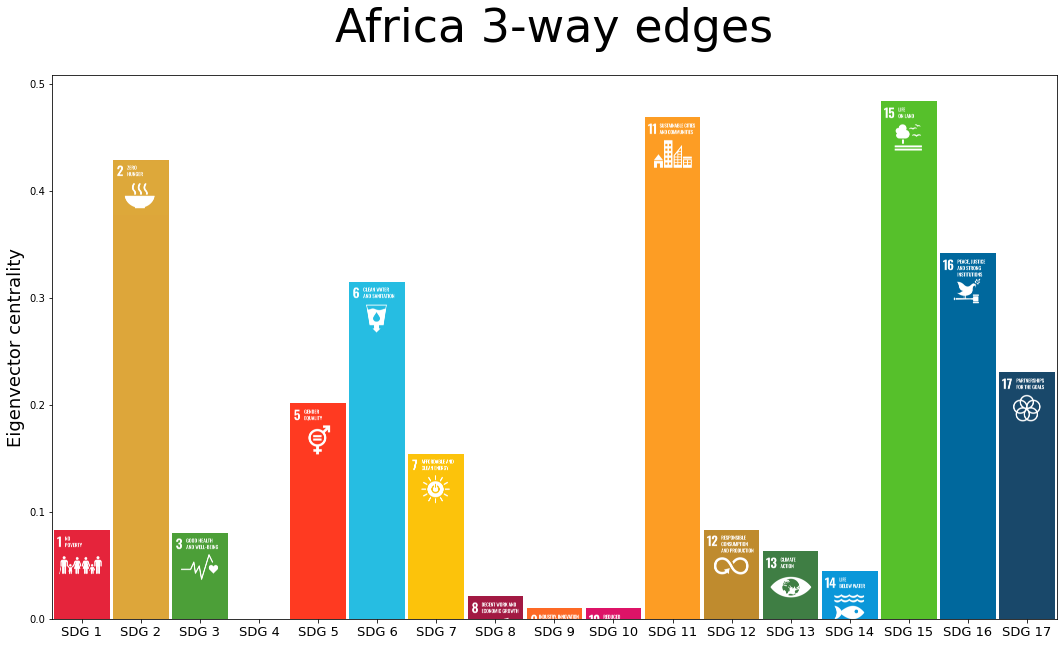

In [38]:
plot_eig_centralities_reorg(g_af3, n_labels_af3, "Africa 3-way edges", "AF3")

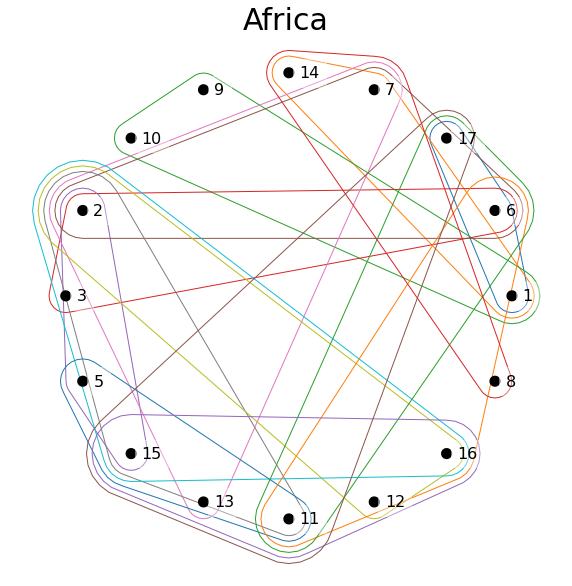

In [39]:
plot_restricted_hypergraphs(Haf_restrict_edges3, 'Africa', 'AF')

In [42]:
Haf_restrict_edges3

Hypergraph({52: Entity(52,['17', '6', '1'],{}), 53: Entity(53,['7', '14', '1'],{}), 54: Entity(54,['10', '9', '1'],{}), 55: Entity(55,['2', '3', '6'],{}), 56: Entity(56,['2', '5', '15'],{}), 57: Entity(57,['2', '7', '6'],{}), 58: Entity(58,['2', '7', '13'],{}), 59: Entity(59,['2', '11', '15'],{}), 60: Entity(60,['2', '12', '16'],{}), 61: Entity(61,['2', '16', '15'],{}), 62: Entity(62,['11', '5', '15'],{}), 63: Entity(63,['11', '16', '6'],{}), 64: Entity(64,['11', '17', '6'],{}), 65: Entity(65,['7', '14', '8'],{}), 66: Entity(66,['11', '16', '15'],{}), 67: Entity(67,['11', '17', '15'],{})},name=_)

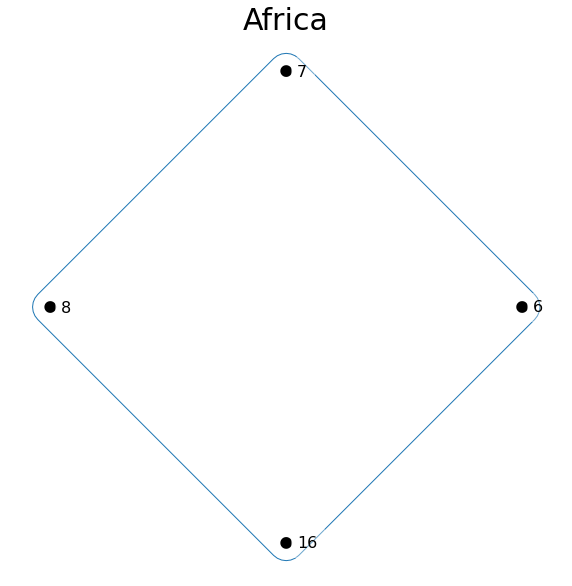

In [24]:
Haf_restrict_edges4 = H_af.restrict_to_edges(list(e for e in edges_af if len(edges_af[e])==4))
plot_restricted_hypergraphs(Haf_restrict_edges4, 'Africa', 'AF4')